<a href="https://colab.research.google.com/github/mvaldenegro/UncertaintyML-course-ESSAI-labs/blob/main/00_tensors_keras_refresher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from matplotlib import pyplot as plt
import numpy as np

## construct a simple dataset for a simple problem

We will fit a sinusoid from a limited number of samples.

The nature of this problem is perfect for this course: we want to accompany predictions with a level of uncertainty. The uncertainty should be low as we get close to the training points, high otherwise.

We create two linear sequences of 15 points with a "hole" in the middle. This will serve as a training data for our machine learning model.

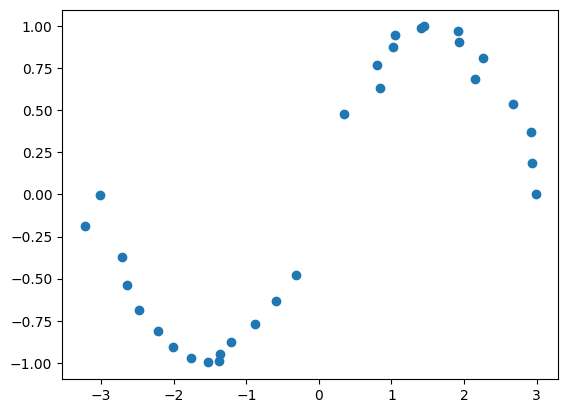

In [ ]:
x_max = 3.14
x_min_pos = 0.5
n = 30
assert n//2 != 0, f"Only even number of data allowed (current {n})"

x = np.concatenate([np.linspace(-x_max, -x_min_pos, num=n//2), np.linspace(x_min_pos, x_max, num=n//2)])
y = np.sin(x)
x += np.random.normal(0, 0.1, x.shape)



# plot the data
plt.scatter(x, y)

This dataset could be fit pretty easily by a plethora of very simple machine learning models; however, in this course we are mainly focused on neural networks (NNs).

Specifically, we will quickly review how to train a very small NN using Keras as a refresher of this library.

### Detour on tensors

Tensorflow (and PyTorch) revolve around the concept of tensor.
For our purposes, we can view the tensor as an extension of the concept of vector and matrix into $n$ dimensions.

A vector of size $k_1$ can be seen as an ordered collection of $k_1$ scalars. We represent it as a vertical stack.

![](https://drive.google.com/uc?export=view&id=1o2RiXi7fC3E-GBkL_rLxuFVi6OV1nrqV)

A vector is ideal for representing lists of homogeneous data: for instance, we can think of having a reading of a sensor for $k_1$ time steps.

The matrix adds another dimension of size $k_2$. We can represent it by repeating the previous vector of size $k_1$ for $k_2$ times, then stack these slices horizontally, thus obtaining a grid of size $k_1$ times $k_2$:

![](https://drive.google.com/uc?export=view&id=1334LpKUNNS5JjGdPzvNzAUFlwFBMDA63)

By extending the previous sensor example, we can have $k_2$ different sensors, each with its $k_1$ readings. We can store these data into a matrix.

We can extend the matrix to a generic 3-dimensional structure by doing as we did with the extension from vector to matrix: just repeat the matrix structure $k_3$ times and stack them together.

![](https://drive.google.com/uc?export=view&id=1QGeBKzjrcgk6zl14qoPrldNlQMtOFfaI)

We have now obtained a 3-d **tensor** of dimension $k_1 \times k_2 \times k_3$. Recalling the sensor example, we can now extend this example to fit into a 3-d tensor.
Let us suppose that our company has several facilities (specifically $k_3$ of them), each facility having $k_2$ tensors recording $k_1$ readings in a defined time frame. We can store these readings separately in each matrix, and stack them together into a 3-d tensor.
Generically, a 3-d tensor can also be seen as a **list of matrices** all having the **same shape**.

![](https://drive.google.com/uc?export=view&id=1bLQXRB4bqzf3LhbD4_ihsXqp3r7xc_ku)

The extension to a 4-d tensor is then simple: a list of 3-d tensor of the same shape, or a list of list of matrices.
Notice that **all sub-structures have the same shape**.

![](https://drive.google.com/uc?export=view&id=176sAfZ4UOrpytY_5DxoVxY52UFxmwyrm)


#### Tensors in Python

There exist many libraries introducing the concept of tensors or $n$-dimensional arrays in Python, the most famous one being `numpy`, where they are called `ndarray`s.
We have previously defined `x` as a one-dimensional array.
Next, we defined `y` by applying `np.sin`, a numpy function, to `x`. This function is applied element-wise to `x`, and thus produces a new one-dimensional array of the same shape as `x`.

In [ ]:
print("x")
print(x, "\n")

print("y")
print(y, "\n")

print("Shape of x:", x.shape)
print("Shape of y:", y.shape)

x
[-3.14       -2.95142857 -2.76285714 -2.57428571 -2.38571429 -2.19714286
 -2.00857143 -1.82       -1.63142857 -1.44285714 -1.25428571 -1.06571429
 -0.87714286 -0.68857143 -0.5         0.5         0.68857143  0.87714286
  1.06571429  1.25428571  1.44285714  1.63142857  1.82        2.00857143
  2.19714286  2.38571429  2.57428571  2.76285714  2.95142857  3.14      ] 

y
[-0.00159265 -0.18902002 -0.36974589 -0.5373628  -0.68592809 -0.81017453
 -0.9056971  -0.96910913 -0.99816243 -0.99182694 -0.95032728 -0.87513478
 -0.7689153  -0.63543475 -0.47942554  0.47942554  0.63543475  0.7689153
  0.87513478  0.95032728  0.99182694  0.99816243  0.96910913  0.9056971
  0.81017453  0.68592809  0.5373628   0.36974589  0.18902002  0.00159265] 

Shape of x: (30,)
Shape of y: (30,)


We can immediately notice that we have used no explicit loops to compute `y`. If we used lists to store the values of `x`, we would have needed to write the following:
```python
import math

y = []
for element in x:
  y = math.sin(x)
```

or, using list comprehensions:

```python
import math

y = [math.sin(element) for element in x]
```

These code pieces force the construction of `y` element-by-element, in a sequential way.
Instead, by using tensors and function for tensors, we are implicitly using all sorts of vectorized computations which exploit parallelism in the CPU (or, as we will later see, in GPUs) to get much faster results.

On to $n$-dimensional arrays, we can construct them quickly in NumPy using one of four functions:

```python
shape = (2,3,5,4) # a list or tuple containing the shape of the tensor
np.zeros(shape) # -> creates a tensor of zeros of the desired shape
np.ones(shape) #  -> creates a tensor of ones of the desired shape
np.empty(shape) # -> creates an empty tensor of the desired shape
                #    Note that the content is absolutely garbage!
np.full(shape, fill_value=np.pi) # -> creates a tensor with the desided shape, all elements will have the specified fill_value
```

In [ ]:
full_tensor = np.full((2, 3, 5, 4), np.pi)

print(full_tensor)
print("Shape:", full_tensor.shape)

[[[[3.14159265 3.14159265 3.14159265 3.14159265]
   [3.14159265 3.14159265 3.14159265 3.14159265]
   [3.14159265 3.14159265 3.14159265 3.14159265]
   [3.14159265 3.14159265 3.14159265 3.14159265]
   [3.14159265 3.14159265 3.14159265 3.14159265]]

  [[3.14159265 3.14159265 3.14159265 3.14159265]
   [3.14159265 3.14159265 3.14159265 3.14159265]
   [3.14159265 3.14159265 3.14159265 3.14159265]
   [3.14159265 3.14159265 3.14159265 3.14159265]
   [3.14159265 3.14159265 3.14159265 3.14159265]]

  [[3.14159265 3.14159265 3.14159265 3.14159265]
   [3.14159265 3.14159265 3.14159265 3.14159265]
   [3.14159265 3.14159265 3.14159265 3.14159265]
   [3.14159265 3.14159265 3.14159265 3.14159265]
   [3.14159265 3.14159265 3.14159265 3.14159265]]]


 [[[3.14159265 3.14159265 3.14159265 3.14159265]
   [3.14159265 3.14159265 3.14159265 3.14159265]
   [3.14159265 3.14159265 3.14159265 3.14159265]
   [3.14159265 3.14159265 3.14159265 3.14159265]
   [3.14159265 3.14159265 3.14159265 3.14159265]]

  [[3.1415

We can additionally use functions to create random tensors, like
`np.random.rand` (for sampling uniformly the elements of the tensors between 0 and 1) or `np.random.randn` (for sampling elements from a standard Gaussian distribution). See the [documentation for NumPy random generation](https://numpy.org/doc/stable/reference/random/legacy.html) for additional info.

In [ ]:
np.random.randn(3,3,4)

array([[[ 0.73139139, -1.84111706, -0.3786717 ,  1.47080778],
        [ 1.2964979 , -1.54767405,  0.0156995 ,  0.09763597],
        [-0.09209147,  1.79096658, -1.20780056, -1.65014604]],

       [[-1.52821575, -0.85428548, -0.44114732, -2.12977187],
        [-1.14808707,  0.01458362,  0.06163712, -0.22360333],
        [ 0.91090155,  1.28093638,  0.35896574, -0.02407398]],

       [[ 1.09398795, -1.8042315 ,  0.70963403,  1.00744955],
        [-0.69612781,  0.54921579,  1.17882837,  0.03924421],
        [ 0.29707711,  0.8734152 , -0.88011707,  1.54786768]]])

Before going on to Keras, it's worth to concentrate on the tensors data types and operations.

Conversely to lists, tensors and ndarrays can hold data of the same type. That means only bools, ints, floats, etc. of the same precision. For instance

In [ ]:
x.dtype

dtype('float64')

We can change the precision of an ndarray by using the function `astype`:

In [ ]:
rand_ndarray = np.random.randn(3, 4)

print(rand_ndarray)
print(rand_ndarray.dtype)

rand_ndarray_float16 = rand_ndarray.astype(np.float16) # same as rand_ndarray.astype("float16")

print(rand_ndarray_float16)
print(rand_ndarray_float16.dtype)

# Be careful at possible loss of information!

rand_ndarray_int8 = rand_ndarray.astype(np.int8) # same as rand_ndarray.astype("int8")

print(rand_ndarray_int8)
print(rand_ndarray_int8.dtype)

[[-1.21545853 -0.04499143 -0.33707021  1.58530116]
 [-0.75297906 -0.07671908 -0.39584752 -0.87811211]
 [-1.33542809 -1.41849018  1.57044568 -0.44058966]]
float64
[[-1.216   -0.04498 -0.3372   1.585  ]
 [-0.753   -0.0767  -0.3958  -0.878  ]
 [-1.335   -1.419    1.57    -0.4407 ]]
float16
[[-1  0  0  1]
 [ 0  0  0  0]
 [-1 -1  1  0]]
int8


We can create subsets of tensors by means of **slicing operators**, which append a set of square brackets `[]` at the end of the tensor name.

This allows us to select one or more element of the tensors, at any position within the hierarchy of dimensions.

`x[0]` select the first element of the first dimension of the tensor `x`. In the case of a 4-d tensor interpretable as a list of 3-d tensors, this will select the first 3-d tensor in this list:

In [ ]:
tensor_4d = np.random.randint(0, 10, (2,3,3,4))

print("tensor_4d:\n", tensor_4d)
print("shape:", tensor_4d.shape, "\n")

print("tensor_4d [0]:\n", tensor_4d[0])
print("shape:", tensor_4d[0].shape, "\n")

tensor_4d:
 [[[[7 1 4 5]
   [6 2 8 0]
   [8 5 7 6]]

  [[3 4 9 0]
   [4 5 0 1]
   [4 9 4 9]]

  [[9 5 8 8]
   [6 8 5 2]
   [9 3 4 4]]]


 [[[7 4 1 0]
   [5 4 4 4]
   [7 2 3 8]]

  [[2 5 0 6]
   [7 7 6 8]
   [9 8 9 9]]

  [[0 4 9 5]
   [1 2 6 3]
   [8 4 7 4]]]]
shape: (2, 3, 3, 4) 

tensor_4d [0]:
 [[[7 1 4 5]
  [6 2 8 0]
  [8 5 7 6]]

 [[3 4 9 0]
  [4 5 0 1]
  [4 9 4 9]]

 [[9 5 8 8]
  [6 8 5 2]
  [9 3 4 4]]]
shape: (3, 3, 4) 



If we want to select a single scalar in our tensor, we have to specify a value for all the four dimensions:

In [ ]:
tensor_4d[0, 1, 1, 3]

1

If we want to select a single structure in the second dimension of the hierarchy, we have to indicate a `:` in the place corresponding to the first:

In [ ]:
tensor_4d[:, 1] # this returns, for all the 3-d tensors in our list, only the second matrix

array([[[3, 4, 9, 0],
        [4, 5, 0, 1],
        [4, 9, 4, 9]],

       [[2, 5, 0, 6],
        [7, 7, 6, 8],
        [9, 8, 9, 9]]])

We can also select multiple elements in the slices. For instance, we can use intervals. For instance, if we want the last two columns of the last matrix of the last 3-d tensor in the list, we can type

In [ ]:
tensor_4d[1, 2, :, 2:4] # 2:4 = select rows from 2 (included) to 4 (not included)

array([[9, 5],
       [6, 3],
       [7, 4]])

For the same task we can also use negative indices in the slice. Negative indices start from the last element (indexed as `-1` and decrease accordingly). `x[-5]` returns the fifth-to-last element of tensor `x`:

In [ ]:
tensor_4d[-1, -1, :, 2:4]

array([[9, 5],
       [6, 3],
       [7, 4]])

We can also omit the `4` in the last position of the slice: this means "pick all elements from 2 to the end"

In [ ]:
print(tensor_4d[-1, -1, :, 2:])

# alternatively, using negative indices

print(tensor_4d[-1, -1, :, -2:])

[[9 5]
 [6 3]
 [7 4]]
[[9 5]
 [6 3]
 [7 4]]


Finally, we may also use lists or tuples in slices to select specifically multiple elements. For instance, if we want the first and last row of each of the matrices contained in our 4d tensor, we will type

In [ ]:
tensor_4d[:, :, (0, -1), :] # alternatively, tensor_4d[:, :, (0, -1)]

array([[[[7, 1, 4, 5],
         [8, 5, 7, 6]],

        [[3, 4, 9, 0],
         [4, 9, 4, 9]],

        [[9, 5, 8, 8],
         [9, 3, 4, 4]]],


       [[[7, 4, 1, 0],
         [7, 2, 3, 8]],

        [[2, 5, 0, 6],
         [9, 8, 9, 9]],

        [[0, 4, 9, 5],
         [8, 4, 7, 4]]]])

On to tensor/ndarray operations:

A sum/subtraction/multiplication/division between a tensor and a scalar will always be interpreted as the same operation between the same scalar and each element of the tensor:

In [ ]:
print("x:")
print(x)

print("2*x:")
print(2*x)

print("x//2: (integer division)")
print(x//2)

x:
[-3.14       -2.95142857 -2.76285714 -2.57428571 -2.38571429 -2.19714286
 -2.00857143 -1.82       -1.63142857 -1.44285714 -1.25428571 -1.06571429
 -0.87714286 -0.68857143 -0.5         0.5         0.68857143  0.87714286
  1.06571429  1.25428571  1.44285714  1.63142857  1.82        2.00857143
  2.19714286  2.38571429  2.57428571  2.76285714  2.95142857  3.14      ]
2*x:
[-6.28       -5.90285714 -5.52571429 -5.14857143 -4.77142857 -4.39428571
 -4.01714286 -3.64       -3.26285714 -2.88571429 -2.50857143 -2.13142857
 -1.75428571 -1.37714286 -1.          1.          1.37714286  1.75428571
  2.13142857  2.50857143  2.88571429  3.26285714  3.64        4.01714286
  4.39428571  4.77142857  5.14857143  5.52571429  5.90285714  6.28      ]
x//2: (integer division)
[-2. -2. -2. -2. -2. -2. -2. -1. -1. -1. -1. -1. -1. -1. -1.  0.  0.  0.
  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.]


We can also apply an operation between tensors when these tensors are **conformable** (same shape). This operation will **always** be interpreted as an element-by-element operation. Be very careful when you want to, e.g., multiply matrices in this way.

In [ ]:
z = np.full_like(x, 2) # matrix of 2's of the same shape as x

print("x * z: (equivalent to x * 2)")
print(x * z)

x * z: (equivalent to x * 2)
[-6.28       -5.90285714 -5.52571429 -5.14857143 -4.77142857 -4.39428571
 -4.01714286 -3.64       -3.26285714 -2.88571429 -2.50857143 -2.13142857
 -1.75428571 -1.37714286 -1.          1.          1.37714286  1.75428571
  2.13142857  2.50857143  2.88571429  3.26285714  3.64        4.01714286
  4.39428571  4.77142857  5.14857143  5.52571429  5.90285714  6.28      ]


The usual matrix multiplication has to be computed differently.
Let us show an example.

$a$ is a $5 \times 4$ matrix, $b$ is a $4 \times 5$ matrix.
We could do $a\cdot b$ to obtain a $5\times 5$ matrix as output:

In [ ]:
a = np.random.rand(5, 4)
print("a:\n", a)
b = np.random.rand(4, 5)
print("b:\n", b)
a*b

a:
 [[0.00681953 0.1630243  0.53162    0.15077388]
 [0.27058237 0.57223329 0.05120527 0.48204166]
 [0.83240173 0.44959148 0.22467559 0.35938522]
 [0.34906629 0.12741809 0.6269242  0.67510059]
 [0.14486282 0.47796046 0.2706756  0.78668482]]
b:
 [[0.19286445 0.93052816 0.17260971 0.31420522 0.13816691]
 [0.46918658 0.52077992 0.89334408 0.26698994 0.65362684]
 [0.04851723 0.86067131 0.83189775 0.46991166 0.075917  ]
 [0.41153045 0.4899663  0.93559714 0.32347148 0.98388349]]


ValueError: ignored

We, instead, have to use `np.dot(a, b)`, which computes the actual multiplication:

In [ ]:
np.dot(a, b)

array([[0.16564483, 0.62266975, 0.730131  , 0.34425407, 0.29620222],
       [0.52152906, 0.8300472 , 1.05150071, 0.41778761, 0.88957274],
       [0.53028159, 1.37816995, 1.06846741, 0.60340992, 0.77952531],
       [0.43534641, 1.26152501, 1.32723944, 0.65667258, 0.84332782],
       [0.58906871, 1.00212291, 1.41318236, 0.55479101, 1.12697811]])

We could also do the same with the transposed matrices. We can transpose the two matrices by typing `a.T` and `b.T`. In this case, their dot product will yield a $4\times 4$ matrix:

In [ ]:
np.dot(a.T, b.T)

array([[0.52647409, 1.07561807, 1.10071434, 1.1696165 ],
       [0.74759839, 1.12256344, 0.97058897, 1.27957451],
       [0.423341  , 0.82111155, 0.57191862, 0.92317786],
       [0.86047958, 1.33727674, 1.0981267 , 1.62685399]])

The operations between tensors also use the concept of **broadcasting**: it is a complex concept that means that NumPy will try and compute the operation even when there is a partial match between the dimensions of two tensors.

In [ ]:
one_row = np.array([[1,2,3,4]])
print("row vector:\n", one_row, "\n\n")
print("row vector (shape 1 x 4) * conformable matrix (shape 5 x 4):\n", a * one_row)

row vector:
 [[1 2 3 4]] 


row vector (shape 1 x 4) * conformable matrix (shape 5 x 4):
 [[0.00681953 0.32604861 1.59486    0.60309552]
 [0.27058237 1.14446658 0.1536158  1.92816664]
 [0.83240173 0.89918296 0.67402678 1.43754089]
 [0.34906629 0.25483618 1.88077261 2.70040236]
 [0.14486282 0.95592092 0.81202679 3.14673928]]


In the above code, we have one row vector, which we have defined by passing a list of a list of five elements to the constructor `np.array`.
In order to muliply this row with a matrix of conformable size, we need three conditions to happen:
1. The number of dimensions of these tensors have to be the same (so, 2)
2. The two tensors must share the exact shape on a subset of their dimensions, at the same indices (so, for instance, dimensions 1, 2, and 5 must match)
3. The other dimensions of one of the two tensors is a _singleton dimension_ (i.e., exactly 1)

In the above case, we have one operand with shape 1 x 4 and another one with shape 5 x 4. The three conditions above are all satisfied, so the operation is carried out.

The result is that all of the rows of the matrix `a` are multiplied, element-by-element, by the same copy of the row vector above defined.
If you notice, the first column is the same as the first column of `a`, the second is multiplied by two, etc.

If we want to obtain the same result with a column vector, we just need to add one transposition while defining this vector, and the job is done:

In [ ]:
one_column = np.array([[1,2,3,4,5]]).T
print("column vector:\n", one_column, "\n\n")
print("column vector (shape 5 x 1) * conformable matrix (shape 5 x 4):\n", a * one_column)

column vector:
 [[1]
 [2]
 [3]
 [4]
 [5]] 


column vector (shape 5 x 1) * conformable matrix (shape 5 x 4):
 [[0.00681953 0.1630243  0.53162    0.15077388]
 [0.54116475 1.14446658 0.10241053 0.96408332]
 [2.49720519 1.34877443 0.67402678 1.07815567]
 [1.39626516 0.50967236 2.50769681 2.70040236]
 [0.72431411 2.38980229 1.35337798 3.9334241 ]]


#### Transitioning from NumPy to Keras

Keras is a library built on top of TensorFlow (TF) to facilitate the development of neural network-based models.
While
**Tensor**flow (TF) is a library for scientific computing, specifically revolving around tensor computations, as the name suggests.

The code for creating and manipulating tensors in TF is very similar to NumPy, although TF tensors have a natural support for GPU computations and are built in such a way to support automatic differentiation using backpropagation. For the sake of this series of labs, we will not go more into the details concerning the differences, as Keras allows also to use NumPy arrays as data for training and evaluating their models.

In [ ]:
tf.constant([[1,2,3],[4,5,6]])

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 2, 3],
       [4, 5, 6]], dtype=int32)>

In [ ]:
tf.random.uniform((2,3)) # as np.random.rand

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.29979408, 0.9386114 , 0.06404459],
       [0.81042206, 0.05644727, 0.07229412]], dtype=float32)>

## Training a NN with Keras

NNs are **frequentist** machine learning models loosely inspired by their biological counterpart: the data enters the NN and passes through some intermediate steps of evaluation, usually encompassing:
* a matrix-matrix (or vector-matrix) product between data and weights
* a non-linear function applied element-wise to each of the outputs of the previous product, which forms a **latent** or **hidden layer** in the computation.
  * the dimension of this latent space is fixed

The output of the final computation of this sequence of steps is the output of our NN.

The process is more easily represented by means of a computational graph, where we put the input on the left. We draw a **node** for each dimension of the input and stack the nodes vertically.
We do the same with all the dimensions of the hidden layers and the output as well.
The output is the rightmost point of this graph.

In the simplest form of NN, the MultiLayer Perceptron (MLP), we have full connectivity between each node of each consecutive layer.
This means that

![](https://raw.githubusercontent.com/ansuini/DSSC_DL_2022/71a0768e2c9370a3e1fff29cddbf45f386df4410/labs/imgs/01/mlp_graph.jpg)

An MLP can be quickly built in Keras using simple building blocks found in the submodule `keras.layers`.

If the information if the NN flows sequentially (i.e., we compute the content of each hidden layer sequentially after the previous layer has been evaluated), we can encapsulate our NN using the very convenient `keras.models.Sequential` structure.

The `Sequential` structure is constructed from a list of layers, like so

In [ ]:
model = keras.models.Sequential([
    keras.Input(shape=(1,)),
    layers.Dense(units=16, activation="relu"),
    layers.Dense(units=16, activation="relu"),
    layers.Dense(units=1)
])

print(model.output_shape)

(None, 1)


In [ ]:
model.compile(
    optimizer="Adam",
    loss="mean_squared_error"
)

In [ ]:
model.fit(
    x, y, epochs = 2000, verbose=1
)

Epoch 1/2000
1/1 [==============================] - 1s 762ms/step - loss: 1.2060
Epoch 2/2000
1/1 [==============================] - 0s 11ms/step - loss: 1.1651
Epoch 3/2000
1/1 [==============================] - 0s 13ms/step - loss: 1.1252
Epoch 4/2000
1/1 [==============================] - 0s 13ms/step - loss: 1.0865
Epoch 5/2000
1/1 [==============================] - 0s 11ms/step - loss: 1.0489
Epoch 6/2000
1/1 [==============================] - 0s 13ms/step - loss: 1.0125
Epoch 7/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.9771
Epoch 8/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.9429
Epoch 9/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.9099
Epoch 10/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8780
Epoch 11/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8472
Epoch 12/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.8176
Epoch 13/2000
1/1 [==================

1/1 [==============================] - 0s 36ms/step


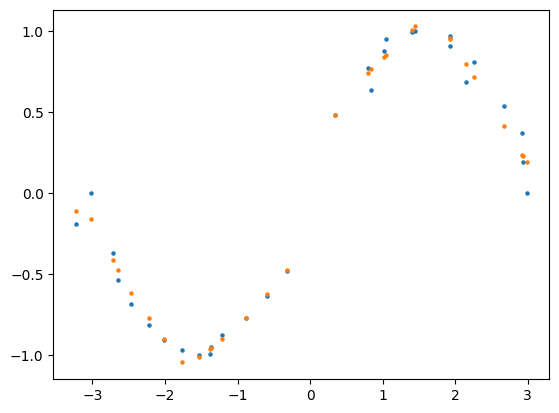

In [ ]:
y_pred = model.predict(x)

plt.scatter(x, y, s=5)
plt.scatter(x, y_pred, s=5)

#### Testing our model

We can now test our model. We randomly sample a set of `m` points and proceed to test the effectiveness of our model.

In [ ]:
x_test = np.linspace(-3.14, 3.14, 1000)
y_test_true = np.sin(x_test)

In [ ]:
y_test_pred = model.predict(x_test)

32/32 [==============================] - 0s 1ms/step


In [ ]:
keras.losses.MeanSquaredError()(y_test_pred, y_test_true)

<tf.Tensor: shape=(), dtype=float64, numpy=1.0260485417847818>

In [ ]:
def plot_prediction(x, y_true, y_pred, x_max, x_min_pos):
  plt.scatter(x, y_true, s=5)
  plt.scatter(x, y_pred, s=5)
  yline = (
      min(y_true.min().item(), y_pred.min().item()),
      max(y_true.max().item(), y_pred.max().item())
  )
  plt.vlines((-x_max, -x_min_pos, x_min_pos, x_max), ymin=yline[0], ymax=yline[1], colors="black")
  x1 = np.array((-x_max, -x_min_pos))
  x2 = np.array((x_min_pos, x_max))
  y1 = np.array([yline[1], yline[1]])
  y2 = np.array([yline[0], yline[0]])
  plt.fill_between(x1, y1, y2, where=(y1 > y2), color="yellow", alpha=.3)
  plt.fill_between(x2, y1, y2, where=(y1 > y2), color="yellow", alpha=.3)

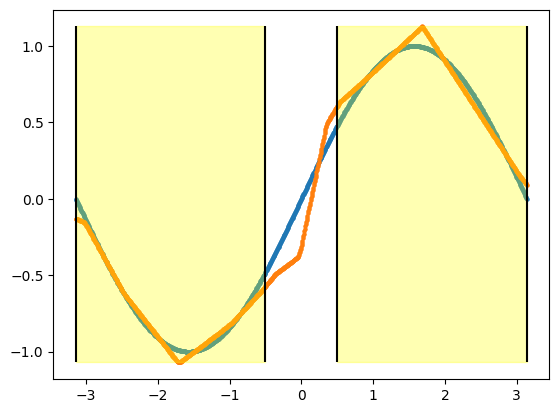

In [ ]:
plot_prediction(x_test, y_test_true, y_test_pred, x_max, x_min_pos)

**Q: _comment on this chart? Do you know why are those rough edges present?_**

#### Testing outside of the range $[-\pi,\pi]$

In [ ]:
x_test_out = np.concatenate([np.linspace(-7, -x_max, 1000), np.linspace(x_max, 7, 1000)])
y_test_out_true = np.sin(x_test_out)
y_test_out_pred = model.predict(x_test_out)

63/63 [==============================] - 0s 2ms/step


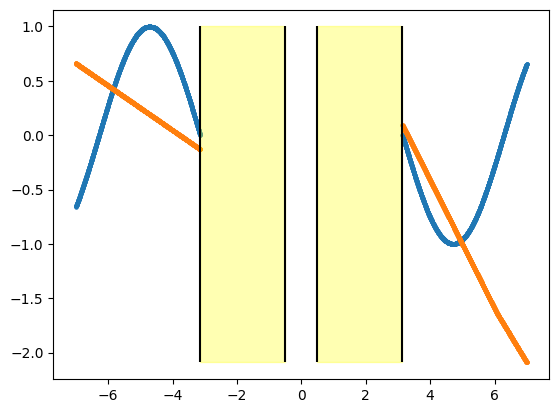

In [ ]:
plot_prediction(x_test_out, y_test_out_true, y_test_out_pred, x_max, x_min_pos)

**Q: _why are the predictions so seemingly random outside of the range $[-\pi, \pi]$?_**

#### Combining everything



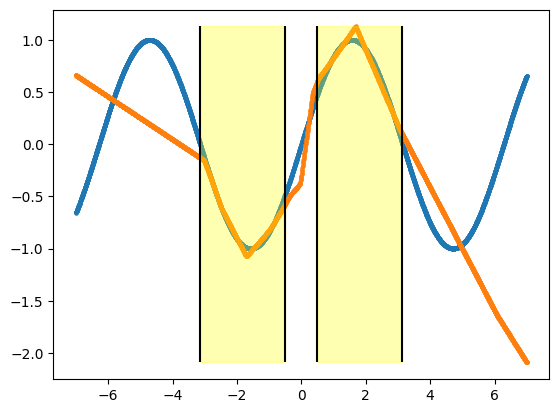

In [ ]:
x_test_all = np.concatenate([x_test, x_test_out])
y_test_all_true = np.concatenate([y_test_true, y_test_out_true])
y_test_all_pred = np.concatenate([y_test_pred, y_test_out_pred])
plot_prediction(x_test_all, y_test_all_true, y_test_all_pred, x_max, x_min_pos)

This introductory notebook was just a preview of things to come. Let's start working with BNNs next!